In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')
data.dropna(inplace = True)
data

,VISITOR_ID,EVENT,CREATED
3,44cf11c0-1916-4a7a-9742-733c37bad393,pageview,2022-09-27T18:40:29.089023696Z
4,ef91fa1c-bdf8-4464-b210-21476b641dcb,pageview,2022-09-27T17:55:05.283031715Z
5,cf1f040b-dcd5-4e7d-86ff-fe13f18bf267,post-read-mid,2022-09-27T17:19:24.532676373Z
6,5f2c6f11-0bef-4871-b2b8-4eb28a4d003b,pageview,2022-09-27T17:00:25.567739511Z
7,b25aac92-44ea-448b-9ce7-e2aff382a38a,post-read-start,2022-09-27T18:23:14.84872485Z
...,...,...,...
10720296,d8c3f190-d135-4845-8da6-eccfc1017c1e,post-read-end,2022-08-14T08:45:34.89919503Z
10720325,3e2723a0-5a00-47c7-9bba-f8930aef60e0,pageview,2022-06-14T11:57:50.559524056Z
10720326,9ec39687-7ab0-44ec-b1ad-944d6dc61bc2,pageview,2022-06-13T11:31:42.12646514Z
10720327,ffee41a2-795d-4625-bf1d-05ea6db26ff2,pageview,2022-06-15T06:17:35.644775696Z


In [96]:
len(np.unique(data[['VISITOR_ID']]))

1422154

In [27]:
user_seqs = data.sort_values('CREATED').groupby('VISITOR_ID')

In [28]:
users = list(user_seqs.groups.keys())

In [99]:
from datetime import datetime

diff_list = []
for user in users:
    event_times = user_seqs.get_group(user).CREATED
    # Calculating difference list
    for x, y in zip(event_times[0::], event_times[1::]):
        xt = datetime.strptime(' '.join(x.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        yt = datetime.strptime(' '.join(y.split('T'))[:22], '%Y-%m-%d %H:%M:%S.%f')
        diff_list.append(yt-xt)
        

In [100]:
time_gaps = pd.DataFrame({'Time': diff_list})

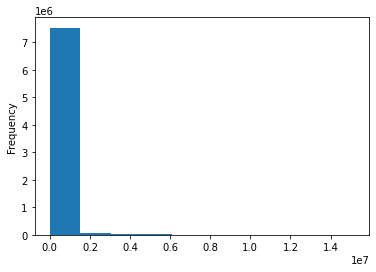

In [101]:
import matplotlib.pyplot as plt
time_gaps = time_gaps.Time.astype('timedelta64[s]')#[time_gaps.Time.astype('timedelta64[s]') > 60*60*24]
time_gaps.plot.hist();

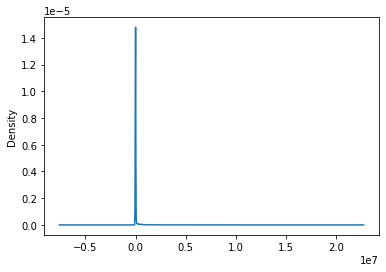

In [102]:
time_gaps.plot.kde();

In [103]:
exp_mean = time_gaps.mean()
lam = 1/exp_mean
lam

1.1334231050308736e-05

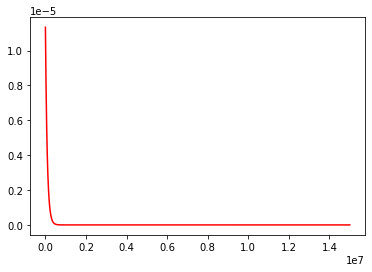

In [108]:
def f(x):
    return lam*np.exp(-lam*x)

x = np.linspace(0, 15000000, 1000)

plt.plot(x, f(x), color='red');

In [106]:
idle = -exp_mean*np.log(0.05)
idle

264308.38230286376

Assuming the events behave as a Poisson random process (which might be a bit of a bold assumption here...), we can model the time between events as an exponential random variable and approximate its parameter lambda to be the mean of the event gaps. Then, in order to determine the idle period length, let us consider the value corresponding to the 95% quantile of the CDF to be an appropirate choice. This yield 264308.38230286376 as our threshold value for an idle period.